# Chapter 4: Tactical portfolio management

### 4.1. How dynamic methods works?
> ###### 4.1.1. Short a stock
> ###### 4.1.2. Momentum factor
> ###### 4.1.3. Rebalancing

### 4.2. Moving average strategy
> ###### 4.2.1. Moving average 
> ###### 4.2.2. Moving average factor
> ###### 4.2.3. Build the strategy

### 4.3. Correlation strategy
> ###### 4.3.1. Correlation
> ###### 4.3.2. Correlation factor
> ###### 4.3.3. Build the strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation of data
list_tickers = ['^DJI','CL=F','^GSPC']
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

[*********************100%***********************]  3 of 3 completed


### 4.2.1. Moving average

In [8]:
# Create the SMA15 for the stocks
data["SMA15 ^DJI"] = data["^DJI"].rolling(15).mean().shift(1)
data["SMA15 CL=F"] = data["CL=F"].rolling(15).mean().shift(1)
data["SMA15 ^GSPC"] = data["^GSPC"].rolling(15).mean().shift(1)

# Create a SMA60
data["SMA60 CL=F"] = data["CL=F"].rolling(60).mean().shift(1)

# Plot the data
print(data)

                  CL=F          ^DJI        ^GSPC      SMA15 FB  SMA15 NFLX  \
Date                                                                          
2000-08-23   32.049999  11144.650391  1505.969971           NaN         NaN   
2000-08-24   31.629999  11182.740234  1508.310059           NaN         NaN   
2000-08-25   32.049999  11192.629883  1506.449951           NaN         NaN   
2000-08-28   32.869999  11252.839844  1514.089966           NaN         NaN   
2000-08-29   32.720001  11215.099609  1509.839966           NaN         NaN   
...                ...           ...          ...           ...         ...   
2022-07-01  108.430000  31097.259766  3825.330078  30827.529167  112.673333   
2022-07-05   99.500000  30967.820312  3831.389893  30749.160547  111.801333   
2022-07-06   98.529999  31037.679688  3845.080078  30720.829297  110.390000   
2022-07-07  102.730003  31384.550781  3902.620117  30755.558594  108.896666   
2022-07-08  104.800003  31338.150391  3899.379883  3

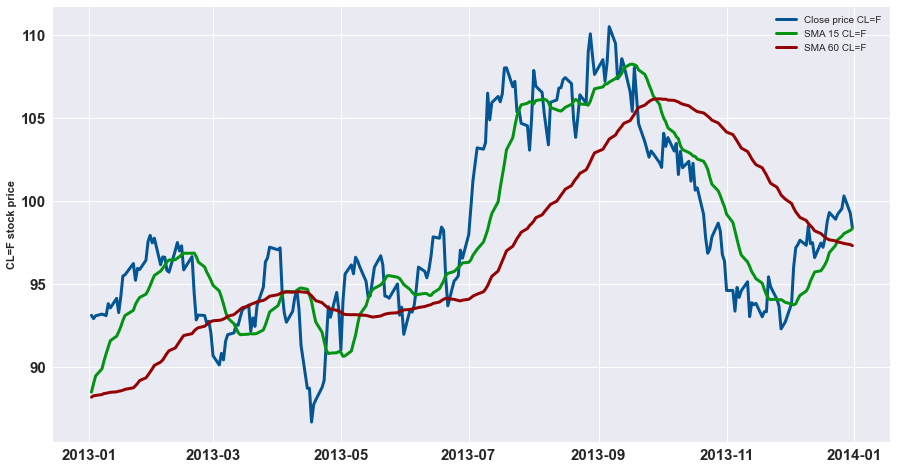

In [9]:
# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(data["CL=F"].loc["2013"], color="#035593", linewidth=3)
plt.plot(data["SMA15 CL=F"].loc["2013"], color="#039313", linewidth=3)
plt.plot(data["SMA60 CL=F"].loc["2013"], color="#930303", linewidth=3)
plt.ylabel("CL=F stock price",fontweight="bold")
plt.legend(["Close price CL=F", "SMA 15 CL=F", "SMA 60 CL=F"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

<br>

### 4.2.2. Moving average factor

###### From this point the data are monthly and not daily

In [5]:
# We need monthly data now

# Importation of data
list_tickers = ["FB", "NFLX", "TSLA"]
database = yf.download(list_tickers, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

# Display the data
data

[*********************100%***********************]  3 of 3 completed


,FB,NFLX,TSLA
Date,,,
2012-06-01,31.100000,9.784286,6.258000
2012-07-01,21.709999,8.121429,5.484000
2012-08-01,18.059999,8.531429,5.704000
2012-09-01,21.660000,7.777143,5.856000
2012-10-01,21.110001,11.320000,5.626000
...,...,...,...
2021-06-01,347.709991,528.210022,679.700012
2021-07-01,356.299988,517.570007,687.200012
2021-08-01,379.380005,569.190002,735.719971


In [11]:
# Create the all necessary SMA
list_tickers =  ['^DJI','CL=F','^GSPC']

# We do a loop to create the SMAs for each asset
for col in list_tickers:
    data[f"pct {col}"] = data[col].pct_change(1)
    data[f"SMA3 {col}"] = data[col].rolling(3).mean().shift(1)
    data[f"SMA12 {col}"] = data[col].rolling(12).mean().shift(1)
    data[f"Momentum factor {col}"] = data[f"SMA3 {col}"] - data[f"SMA12 {col}"]

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the mean and std vectors
columns = [f"Momentum factor {col}" for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

<br>

### 4.2.3. Build the strategy

In [12]:
# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct {list_tickers[i]}"]

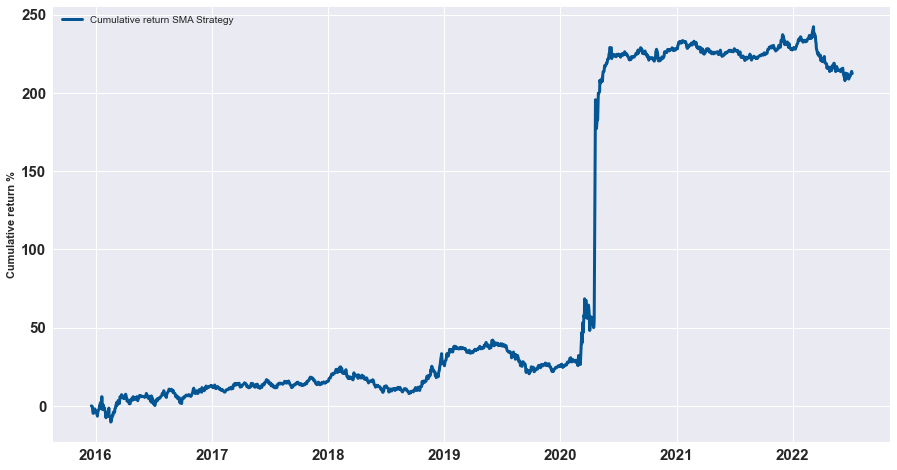

In [13]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return SMA Strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.498 	 Alpha: 1.82 %	     Sharpe: 0.148 	 Sortino: 0.43
  -----------------------------------------------------------------------------
    VaR: 22.69 %	 cVaR: 26.27 % 	     VaR/cVaR: 1.158 	 drawdown: 29.84 %
  -----------------------------------------------------------------------------


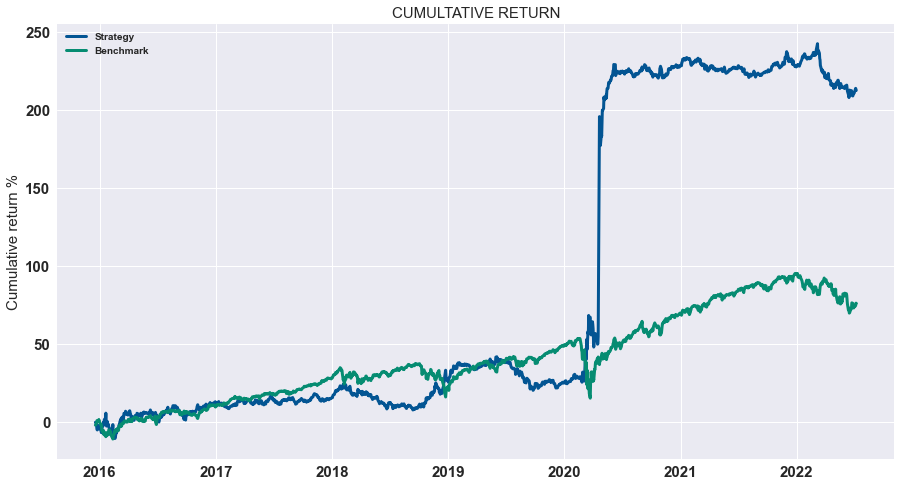

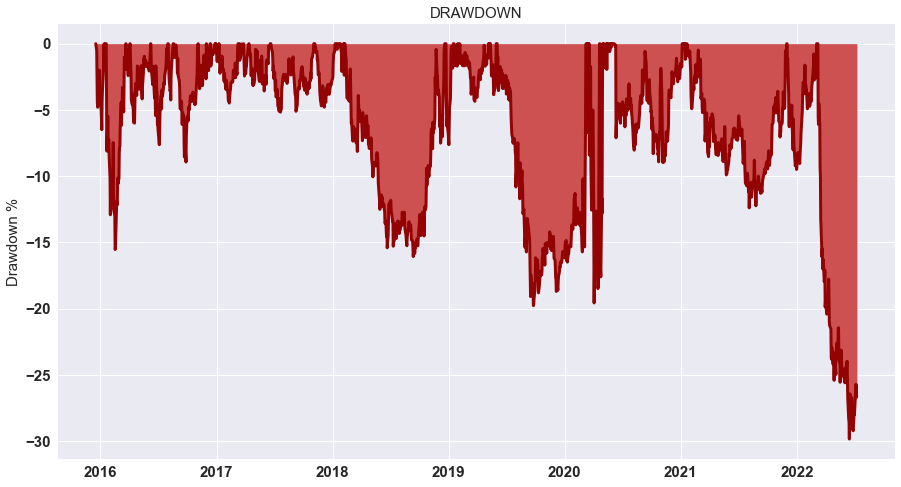

In [14]:
# Code created in the chapter 5
from Backtest import *
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)

<br>
<br>
<br>



### 4.3.1. Correlation

In [15]:
# Plot absolute price correlation
data[list_tickers].corr()

,^DJI,CL=F,^GSPC
^DJI,1.000000,0.108215,0.993410
CL=F,0.108215,1.000000,0.092293
^GSPC,0.993410,0.092293,1.000000


In [17]:
# Plot returns correlation
data[list_tickers].pct_change(1).corr()

,^DJI,CL=F,^GSPC
^DJI,1.000000,0.138409,0.970682
CL=F,0.138409,1.000000,0.137993
^GSPC,0.970682,0.137993,1.000000


,^DJI,CL=F,^GSPC
^DJI,1.000000,0.138409,0.970682
CL=F,0.138409,1.000000,0.137993
^GSPC,0.970682,0.137993,1.000000


<br>

### 4.3.2. Trend return factor

In [18]:
# Our stocks list
list_ = ["TSLA", "GOOG", "FB", "NVDA", "PYPL", "CMCSA", "INTC", "NFLX"] 

In [19]:
# We need monthly data now

# Importation of data
database = yf.download(list_, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

#Display the data
data

[*********************100%***********************]  8 of 8 completed


,CMCSA,FB,GOOG,INTC,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-08-01,24.573635,89.430000,618.250000,23.582989,115.029999,5.448278,35.000000,49.812000
2015-09-01,24.813570,89.900002,608.419983,25.111986,103.260002,5.999339,31.040001,49.680000
2015-10-01,27.317610,101.970001,710.809998,28.211411,108.379997,6.904716,36.009998,41.386002
2015-11-01,26.663342,104.239998,742.599976,28.969603,123.330002,7.720039,35.259998,46.051998
2015-12-01,24.722517,104.660004,758.880005,28.905178,114.379997,8.052295,36.200001,48.001999
...,...,...,...,...,...,...,...,...
2022-02-01,46.185974,211.029999,2697.820068,46.968117,394.519989,243.756943,111.930000,870.429993
2022-03-01,46.245239,222.360001,2792.989990,49.171318,374.589996,272.755859,115.650002,1077.599976
2022-04-01,39.271908,200.470001,2299.330078,43.248135,190.360001,185.430801,87.930000,870.760010


In [21]:
# Compute the lookback and hold period
for col in list_:
    data[f"pct+1 {col}"] = data[f"{col}"].pct_change(-1)
    data[f"pct-12 {col}"] = data[f"{col}"].pct_change(12)

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]


# Compute the correlation
corr = []
for col in list_:
    cor = train_set[[f"pct-12 {col}", f"pct+1 {col}"]].corr().values[0][1]

    corr.append(cor)

correlation = pd.DataFrame(corr, index=list_, columns=["Corr"])
correlation.sort_values(by="Corr", ascending=False)

,Corr
INTC,0.337824
GOOG,0.279383
PYPL,0.225069
CMCSA,0.184705
FB,0.146757
NFLX,0.108767
TSLA,-0.106216
NVDA,-0.142475


<br>

### Build the strategy

In [22]:
best = ["PYPL", "INTC", "GOOG"]

# Find the mean and std vectors
columns = [f"pct-12 {col}" for col in best]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct+1 {best[i]}"]

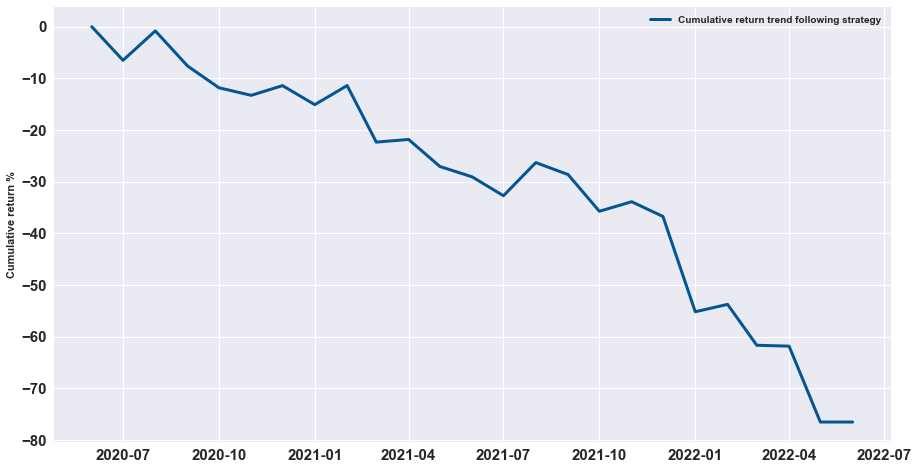

In [24]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return trend following strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.1 	 Alpha: -29.57 %	     Sharpe: -1.802 	 Sortino: -2.138
  -----------------------------------------------------------------------------
    VaR: 83.94 %	 cVaR: 90.6 % 	     VaR/cVaR: 1.079 	 drawdown: 56.1 %
  -----------------------------------------------------------------------------


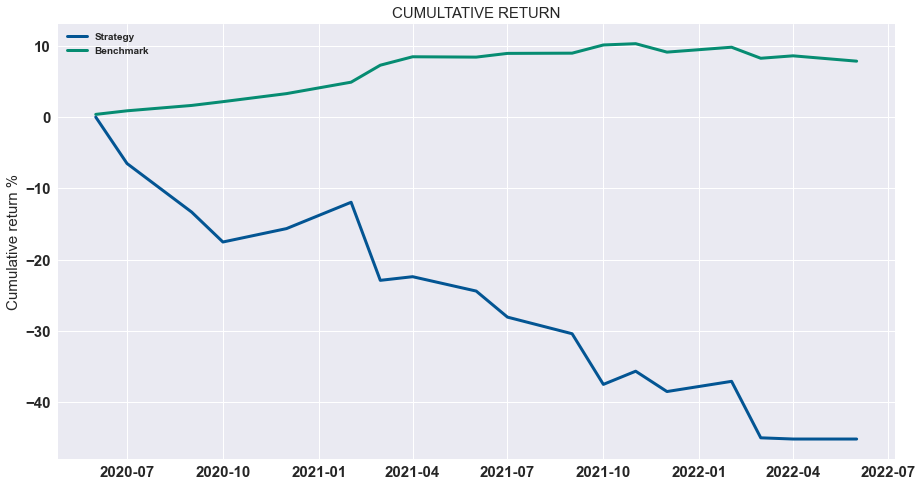

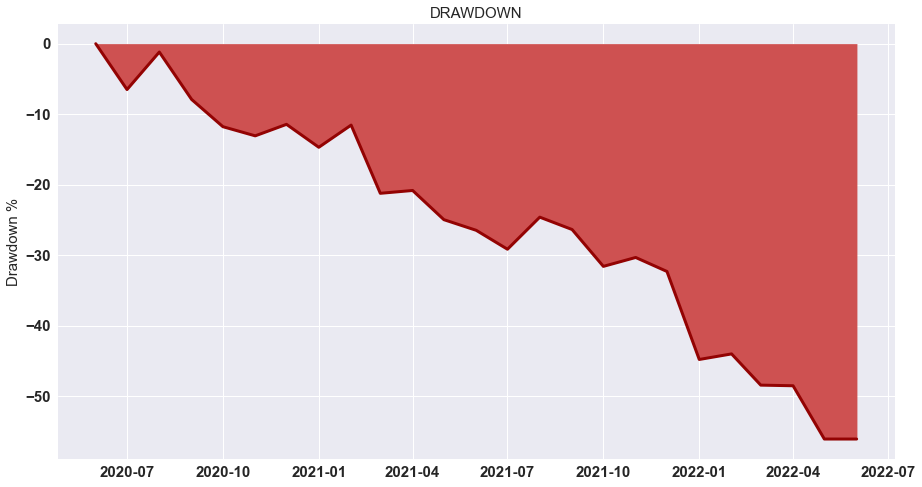

In [25]:
from Backtest import backtest_dynamic_portfolio
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)